## CNN-Text Classification

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, random_split, Subset, Dataset
import torchvision.transforms as transforms

import torchvision
from sklearn.utils import shuffle

from numpy.random import seed
import torch
import numpy as np

from torchinfo import summary
import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv("Emotion_final.csv")
data.head()
len(data)

data = shuffle(data)

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


21459

In [ ]:
# Map text label to numbers

label_map = {'fear':0, 'happy':1, 'anger':2, 'surprise':3, 'sadness':4, 'love':5}
data["label"] = data.Emotion.apply(lambda x: label_map[x])
data.head()
data.label.value_counts()

,Text,Emotion,label
11319,i feel impatient with the christian church dis...,anger,2
793,i feel like him try to stay as faithful as pos...,happy,1
11516,im feeling pretty proud most of the elements i...,happy,1
18681,i went to bed feeling pretty proud of myself e...,happy,1
2273,i feel heartbroken mostly for my daughter and ...,sadness,4


1    7029
4    6265
2    2993
0    2652
5    1641
3     879
Name: label, dtype: int64

In [ ]:
# Split dataset into training, evaluation, and test

train_data = data.iloc[0: 15000]
eval_data = data.iloc[15000: 18000]
test_data = data.iloc[18000: ]

### Q3.1. Preprocess Text

[]

15959

0    14985
1      486
2      165
3       70
4       48
6       27
7       20
5       18
9       12
8        9
dtype: int64

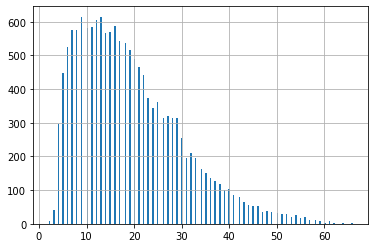

In [ ]:
# A few exploration steps
from tensorflow import keras

# check document length
(train_data.apply(lambda row: len(row["Text"].split()), axis = 1)).hist(bins = 200).plot()
#(train_data.apply(lambda row: len(row["title"].split()), axis = 1)).hist(bins = 200).plot()

# check word frequencies
tokenizer = keras.preprocessing.text.Tokenizer()
#tokenizer.fit_on_texts(train_data["title"] +" "+ train_data["text"])
tokenizer.fit_on_texts(train_data["Text"])

len(tokenizer.word_counts)
word_counts = pd.Series(list(tokenizer.word_counts.values()))
(word_counts//30).value_counts().sort_values(ascending = False)[0:10]

In [ ]:
class News_dataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.Tensor(x).long()
        self.y = torch.Tensor(y).long()
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.x.size()[0]


In [ ]:
def preprocess(train_data, eval_data, test_data, vocab_size = 10000, max_sent = 50):
    
    tokenizer = keras.preprocessing.text.Tokenizer(num_words = vocab_size)
    tokenizer.fit_on_texts(train_data["Text"])

    train_seq = tokenizer.texts_to_sequences(train_data["Text"])
    train_seq = keras.preprocessing.sequence.pad_sequences(train_seq,
                                                        value=0,
                                                        padding='post',
                                                        maxlen=max_sent)

    eval_seq = tokenizer.texts_to_sequences(eval_data["Text"])
    eval_seq = keras.preprocessing.sequence.pad_sequences(eval_seq,
                                                        value=0,
                                                        padding='post',
                                                        maxlen=max_sent)

    
    test_seq = tokenizer.texts_to_sequences(test_data["Text"])
    test_seq = keras.preprocessing.sequence.pad_sequences(test_seq,
                                                        value=0,
                                                        padding='post',
                                                        maxlen=max_sent)

    # dataset
    train_dataset = News_dataset(train_seq, train_data["label"].values)
    eval_dataset = News_dataset(eval_seq, eval_data["label"].values)
    test_dataset = News_dataset(test_seq, test_data["label"].values)
    
    return train_dataset, eval_dataset, test_dataset, tokenizer

In [ ]:
vocab_size = 10000
max_sent = 50

train_dataset, eval_dataset, test_dataset, tokenizer = preprocess(train_data, eval_data, test_data, \
                                                       vocab_size, max_sent )

In [ ]:
#tokenizer.word_index

### Load pretrained word vectors

In [ ]:
!pip install torchtext

In [ ]:
import torchtext
emb_dim = 100

vector = torchtext.vocab.GloVe(name='6B', dim=100)

.vector_cache/glove.6B.zip: 862MB [02:41, 5.34MB/s]                             
100%|███████████████████████████████▉| 399999/400000 [00:06<00:00, 64227.45it/s]


In [ ]:

missing_words = []  # check if any word without a vector

# initialize embedding matrix
emb_weight = np.zeros((vocab_size, emb_dim))

# loop through all words
for word, idx in tokenizer.word_index.items():

  # align with word index in sentences, since the first 3 indexes are reserved
  if idx < vocab_size :  
    try:
      emb = vector[word]
      emb_weight[idx] = emb    

    # not every word has a vector
    except:
      missing_words.append(word)
    
print(missing_words)

[]


In [ ]:
emb_matrix = torch.Tensor(emb_weight)
print(emb_matrix.shape)

torch.Size([10000, 100])


### 3.3. Model

In [ ]:
class cnn_text(nn.Module):

    # define all the layers used in model
    def __init__(self, vocab_size, emb_dim, num_classes, num_filters,  \
                 kernel_sizes, emb_weight = None, freeze = False, dropout_rate = 0.5):
      
        super(cnn_text, self).__init__()
        
        self.emb_dim = emb_dim
        
        self.num_filters = num_filters
        self.kernel_sizes = kernel_sizes
        self.num_classes = num_classes
       
        if emb_weight is None:      
            self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx = 0)
        else:
            self.embedding = nn.Embedding.from_pretrained(emb_weight, freeze=freeze)
        
        self.convs = nn.ModuleList([nn.Conv1d(self.emb_dim, self.num_filters, f) for f in self.kernel_sizes])
        self.fc = nn.Linear(len(kernel_sizes)*self.num_filters, self.num_classes)

        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        
        x = self.embedding(x) # Batch x sent_len x emb_dim
        
        x = torch.swapaxes(x, 1, 2) # Batch x emb_dim x max_sent 

        x = [F.relu(conv(x)) for conv in self.convs]  # output of three conv, batch x num_filter x L

        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x] # continue with 3 maxpooling

        x = torch.cat(x, 1)  

        x = self.dropout(x)  

        logit = self.fc(x)  

        return logit

### Train

In [ ]:
from sklearn.metrics import classification_report

def train_model(model, train_dataset, eval_dataset, test_dataset, device, 
                optimizer, epochs=30, batch_size=64):
    
    # construct dataloader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    eval_loader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # move model to device
    model = model.to(device)

    # history
    history = {'train_loss': [],
               'train_acc': [],
               'eval_loss': [],
               'eval_acc': [],
               'test_acc': 0}
    
    patience = 5
    max_acc = -np.Inf
    cnt = 0
    
    # setup loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    #optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)

    # training loop
    print('Training Start')
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_acc = 0
        test_loss = 0
        test_acc = 0
        
        for x, y in train_loader:
            
            # move data to device
            x = x.to(device)
            y = y.to(device)
            
            # forward
            outputs = model(x)  # (num_batch, 45) 
            _, pred = torch.max(outputs, dim = -1)
            cur_train_loss = criterion(outputs, y)
            cur_train_acc = (pred == y).float().mean().item()
            
            # backward
            cur_train_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # loss and acc
            train_loss += cur_train_loss
            train_acc += cur_train_acc

        # test start
        model.eval()
        with torch.no_grad():
            for x, y in eval_loader:
                # move
                x = x.to(device)
                y = y.to(device)
                # predict
                
                outputs = model(x)  # (num_batch, 45) 
                _, pred = torch.max(outputs, dim = -1)
                cur_test_loss = criterion(outputs, y)
                cur_test_acc = (pred == y).float().mean().item() 
                # loss and acc
                test_loss += cur_test_loss
                test_acc += cur_test_acc

        # epoch output
        train_loss = (train_loss/len(train_loader)).item()
        train_acc = train_acc/len(train_loader)
        val_loss = (test_loss/len(eval_loader)).item()
        val_acc = test_acc/len(eval_loader)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['eval_loss'].append(val_loss)
        history['eval_acc'].append(val_acc)
        print(f"Epoch:{epoch + 1} / {epochs}, train loss:{train_loss:.4f},\
        train_acc:{train_acc:.4f}, valid loss:{val_loss:.4f} valid acc:{val_acc:.4f}")
        
        if test_acc > max_acc:
            max_acc = test_acc
            cnt = 0
            torch.save(model.state_dict(), "best_model.pth")
            print("model saved!")
        else:
            cnt += 1
            
            if cnt == patience:
                print("early stopping!")
                break
    
    # restore best model
    model.load_state_dict(torch.load("best_model.pth"))
    
    return model, history

In [ ]:
def test_model(model, test_dataset, batch_size = 64):    # get test performance
    
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    test_acc = 0
    ys = []
    preds = []
    
    model.eval()
    with torch.no_grad():
        for x, y in test_loader:
            # move
            x = x.to(device)
            y = y.to(device)
            # predict
            outputs = model(x)
            _, pred = torch.max(outputs, dim = -1)
            
            ys.append(y.cpu().numpy())
            preds.append(pred.cpu().numpy())
    
    ys = np.concatenate(ys)
    preds = np.concatenate(preds)
    
    test_acc = (preds == ys).astype(int).mean()
    print(classification_report(ys, preds))
        
    print(f"Test acc: {test_acc:.4f}")
    
    return test_acc

### Training Model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
kernel_sizes = [1, 3, 5]
num_filters = 30
num_classes = 6

In [ ]:
# Case A, randomly initialize embedding layer

model_cnn_a = cnn_text(vocab_size, emb_dim, num_classes, num_filters, \
                 kernel_sizes, emb_weight = None)
                  
#summary(model_cnn, (32, max_sent))

optimizer = torch.optim.Adam(model_cnn_a.parameters(), lr=0.0005)

model_cnn_a, hista = train_model(model_cnn_a, train_dataset, eval_dataset, test_dataset, \
                           device, optimizer, epochs=100)

test_acc = test_model(model_cnn_a, test_dataset)

Training Start
Epoch:1 / 100, train loss:1.6710,        train_acc:0.3111, valid loss:1.5250 valid acc:0.4027
model saved!
Epoch:2 / 100, train loss:1.5506,        train_acc:0.3746, valid loss:1.4777 valid acc:0.4435
model saved!
Epoch:3 / 100, train loss:1.4693,        train_acc:0.4206, valid loss:1.3952 valid acc:0.4840
model saved!
Epoch:4 / 100, train loss:1.3711,        train_acc:0.4806, valid loss:1.2609 valid acc:0.5540
model saved!
Epoch:5 / 100, train loss:1.2243,        train_acc:0.5505, valid loss:1.0681 valid acc:0.6464
model saved!
Epoch:6 / 100, train loss:1.0456,        train_acc:0.6287, valid loss:0.8749 valid acc:0.7203
model saved!
Epoch:7 / 100, train loss:0.8672,        train_acc:0.6977, valid loss:0.6988 valid acc:0.7660
model saved!
Epoch:8 / 100, train loss:0.7045,        train_acc:0.7680, valid loss:0.5657 valid acc:0.8267
model saved!
Epoch:9 / 100, train loss:0.5969,        train_acc:0.8032, valid loss:0.4825 valid acc:0.8461
model saved!
Epoch:10 / 100, train 

In [ ]:
# Case B: Use word vectors and freeze word vectors
model_cnn_b = cnn_text(vocab_size, emb_dim, num_classes, num_filters, \
                 kernel_sizes, emb_weight = emb_matrix, freeze = True)
                  
#summary(model_cnn, (32, max_sent))

optimizer = torch.optim.Adam(model_cnn_b.parameters(), lr=0.0005)

model_cnn_b, hist_b = train_model(model_cnn_b, train_dataset, eval_dataset, test_dataset, \
                           device, optimizer, epochs=100)

test_acc = test_model(model_cnn_b, test_dataset)



Training Start
Epoch:1 / 100, train loss:1.5094,        train_acc:0.4218, valid loss:1.2683 valid acc:0.5615
model saved!
Epoch:2 / 100, train loss:1.1600,        train_acc:0.5914, valid loss:0.9649 valid acc:0.6811
model saved!
Epoch:3 / 100, train loss:0.9656,        train_acc:0.6575, valid loss:0.8122 valid acc:0.7456
model saved!
Epoch:4 / 100, train loss:0.8443,        train_acc:0.6988, valid loss:0.7100 valid acc:0.7723
model saved!
Epoch:5 / 100, train loss:0.7718,        train_acc:0.7269, valid loss:0.6443 valid acc:0.7976
model saved!
Epoch:6 / 100, train loss:0.7101,        train_acc:0.7535, valid loss:0.5920 valid acc:0.8102
model saved!
Epoch:7 / 100, train loss:0.6714,        train_acc:0.7679, valid loss:0.5550 valid acc:0.8199
model saved!
Epoch:8 / 100, train loss:0.6307,        train_acc:0.7814, valid loss:0.5366 valid acc:0.8286
model saved!
Epoch:9 / 100, train loss:0.6075,        train_acc:0.7893, valid loss:0.5080 valid acc:0.8359
model saved!
Epoch:10 / 100, train 

In [ ]:
# Case C: Use word vectors and allow fine tuning

model_cnn_c = cnn_text(vocab_size, emb_dim, num_classes, num_filters, \
                 kernel_sizes, emb_weight = emb_matrix, freeze = False)
                  
#summary(model_cnn, (32, max_sent))

optimizer = torch.optim.Adam(model_cnn_c.parameters(), lr=0.0005)

model_cnn_c, hist_c = train_model(model_cnn_c, train_dataset, eval_dataset, test_dataset, \
                           device, optimizer, epochs=100)

test_acc = test_model(model_cnn_c, test_dataset)



Training Start
Epoch:1 / 100, train loss:1.5117,        train_acc:0.4181, valid loss:1.2247 valid acc:0.5740
model saved!
Epoch:2 / 100, train loss:0.9903,        train_acc:0.6664, valid loss:0.6625 valid acc:0.8020
model saved!
Epoch:3 / 100, train loss:0.5753,        train_acc:0.8143, valid loss:0.3806 valid acc:0.8741
model saved!
Epoch:4 / 100, train loss:0.3875,        train_acc:0.8732, valid loss:0.2774 valid acc:0.8985
model saved!
Epoch:5 / 100, train loss:0.3078,        train_acc:0.8975, valid loss:0.2338 valid acc:0.9101
model saved!
Epoch:6 / 100, train loss:0.2586,        train_acc:0.9118, valid loss:0.2127 valid acc:0.9138
model saved!
Epoch:7 / 100, train loss:0.2258,        train_acc:0.9195, valid loss:0.2023 valid acc:0.9138
Epoch:8 / 100, train loss:0.2136,        train_acc:0.9269, valid loss:0.2001 valid acc:0.9158
model saved!
Epoch:9 / 100, train loss:0.1884,        train_acc:0.9322, valid loss:0.1946 valid acc:0.9168
model saved!
Epoch:10 / 100, train loss:0.1785, 